In [21]:
%autoreload 2

In [22]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [23]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


98 6272 64.0 100352 1024.0


In [24]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,1.00,...,0.976714,0.984956,0.942266,0.970180,0.973574,0.978002,0.725160,0.761936,0.942521,0.975955
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,1.00,...,0.986443,0.986721,0.935275,0.965656,0.967074,0.978883,0.670913,0.801850,0.870098,0.924083
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,0.00,...,0.976849,0.981247,0.000000,0.000000,0.000000,0.000000,0.452633,0.593800,0.814709,0.883131
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,0.00,...,0.986600,0.986476,0.000000,0.000000,0.000000,0.000000,0.725160,0.761936,0.942521,0.975955
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0.25,...,0.985217,0.983768,0.000000,0.000000,0.000000,0.000000,0.937248,0.947704,0.933456,0.976437


In [26]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df

model_name = '2023_03_21_1'
data_df = fitness_df
cv_energy_model, feature_columns = utils.load_model_and_feature_columns(model_name)



## Histogram the weights to get a sense of what we're dealing with

Weights mean: 0.0539, std: 3.7029, bias: 0.0100


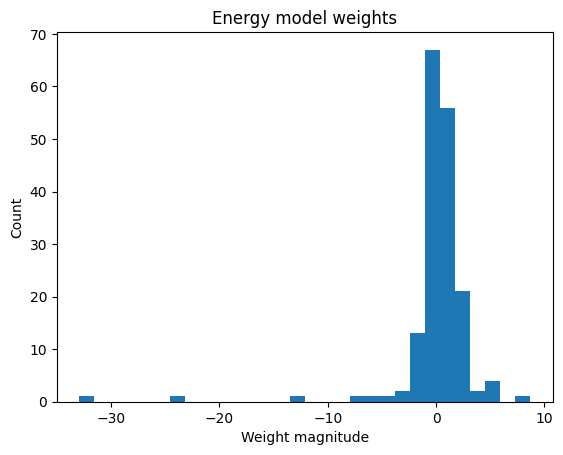

In [27]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=30)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [28]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (18, 10.47%) of the weights have magnitude < 0.1778
Approximately 25.0% (43, 25.00%) of the weights have magnitude < 0.3820
Approximately 50.0% (86, 50.00%) of the weights have magnitude < 0.7312
Approximately 75.0% (130, 75.58%) of the weights have magnitude < 1.6204
Approximately 90.0% (155, 90.12%) of the weights have magnitude < 2.8456
Approximately 95.0% (164, 95.35%) of the weights have magnitude < 4.9666
Approximately 99.0% (171, 99.42%) of the weights have magnitude < 24.0097


## Print the top K features most and least predictive of real games

In [29]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games):')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games):')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games):
1. ast_ngram_full_n_7_score (-32.9286)
2. ast_ngram_constraints_n_7_score (-24.0080)
3. ast_ngram_setup_n_5_score (-12.4967)
4. all_variables_defined (-6.9215)
5. all_variables_used (-5.8120)
6. max_quantification_count_setup_0 (-4.5430)
7. setup_objects_used (-2.9255)
8. node_count_constraints_0 (-2.6675)
9. object_orientation_arg_types_receptacles_orientations_setup (-2.1538)
10. mean_depth_constraints_3 (-1.7729)
11. agent_holds_arg_types_small_objects_constraints (-1.7698)
12. on_arg_types_furniture_furniture_setup (-1.7236)
13. all_preferences_used (-1.6207)
14. adjacent_arg_types_receptacles_room_features_constraints (-1.4565)
15. max_number_variables_types_quantified_variables_1 (-1.3592)
16. adjacent_arg_types_receptacles_room_features_setup (-1.3355)
17. touch_arg_types_balls_ramps_constraints (-1.2323)
18. max_number_variables_types_quantified_types_4 (-1.2167)
19. adjacent_side_3_arg_types_receptacles_sides_blocks_setup (-1.1576)
20. predicate_under_modal_while_hold_in (-1.0877)
### Features with largest positive weights (most predictive of fake games):
1. max_depth_setup_1 (8.6979)
2. repeated_variables_found (5.2622)
3. mean_depth_setup_2 (5.0088)
4. pref_forall_pref_forall_correct_types_incorrect (4.9654)
5. mean_depth_setup_3 (4.5716)
6. mean_depth_setup_4 (3.4987)
7. redundant_expression_found (3.2850)
8. node_count_setup_3 (3.0062)
9. max_depth_setup_2 (2.9336)
10. distance_arg_types_other_constraints (2.8900)
11. agent_holds_arg_types_agent_constraints (2.8394)
12. agent_holds_arg_types_other_constraints (2.7269)
13. agent_holds_arg_types_room_features_constraints (2.7123)
14. in_motion_arg_types_other_constraints (2.6317)
15. in_motion_arg_types_room_features_constraints (2.4695)
16. in_motion_arg_types_other_setup (2.3900)
17. agent_holds_arg_types_other_setup (2.3644)
18. in_motion_arg_types_receptacles_setup (2.2740)
19. in_motion_arg_types_agent_constraints (2.2155)
20. agent_holds_arg_types_receptacles_setup (2.2128)

In [30]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'found' in c]

[('adjacent_once_found', tensor(1.9564)),
 ('repeated_variables_found', tensor(5.2622)),
 ('nested_logicals_found', tensor(2.1396)),
 ('identical_logical_children_found', tensor(1.1647)),
 ('tautological_expression_found', tensor(1.1676)),
 ('redundant_expression_found', tensor(3.2850)),
 ('two_number_operation_found', tensor(-0.0019))]

In [31]:
data_df.groupby('real').two_number_operation_found.describe()

,count,mean,std,min,25%,50%,75%,max
real,,,,,,,,
0,100352.0,0.053601,0.22523,0.0,0.0,0.0,0.0,1.0
1,98.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0


In [32]:
data_df.groupby('real').no_identical_logical_children.describe()

AttributeError: 'DataFrameGroupBy' object has no attribute 'no_identical_logical_children'

In [33]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'number' in c]

[('max_number_variables_types_quantified_types_1', tensor(0.9553)),
 ('max_number_variables_types_quantified_types_2', tensor(-0.0653)),
 ('max_number_variables_types_quantified_types_3', tensor(0.4005)),
 ('max_number_variables_types_quantified_types_4', tensor(-1.2167)),
 ('max_number_variables_types_quantified_types_7', tensor(0.6467)),
 ('max_number_variables_types_quantified_variables_1', tensor(-1.3592)),
 ('max_number_variables_types_quantified_variables_2', tensor(0.0064)),
 ('max_number_variables_types_quantified_variables_3', tensor(0.1622)),
 ('two_number_operation_found', tensor(-0.0019))]

In [34]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if c.startswith('ast_ngram') and c.endswith('score')]

[('ast_ngram_full_n_7_score', tensor(-32.9286)),
 ('ast_ngram_setup_n_5_score', tensor(-12.4967)),
 ('ast_ngram_constraints_n_7_score', tensor(-24.0080))]

## Plot a histogram of the values for each of the and bottom K features

In [35]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {feature_columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

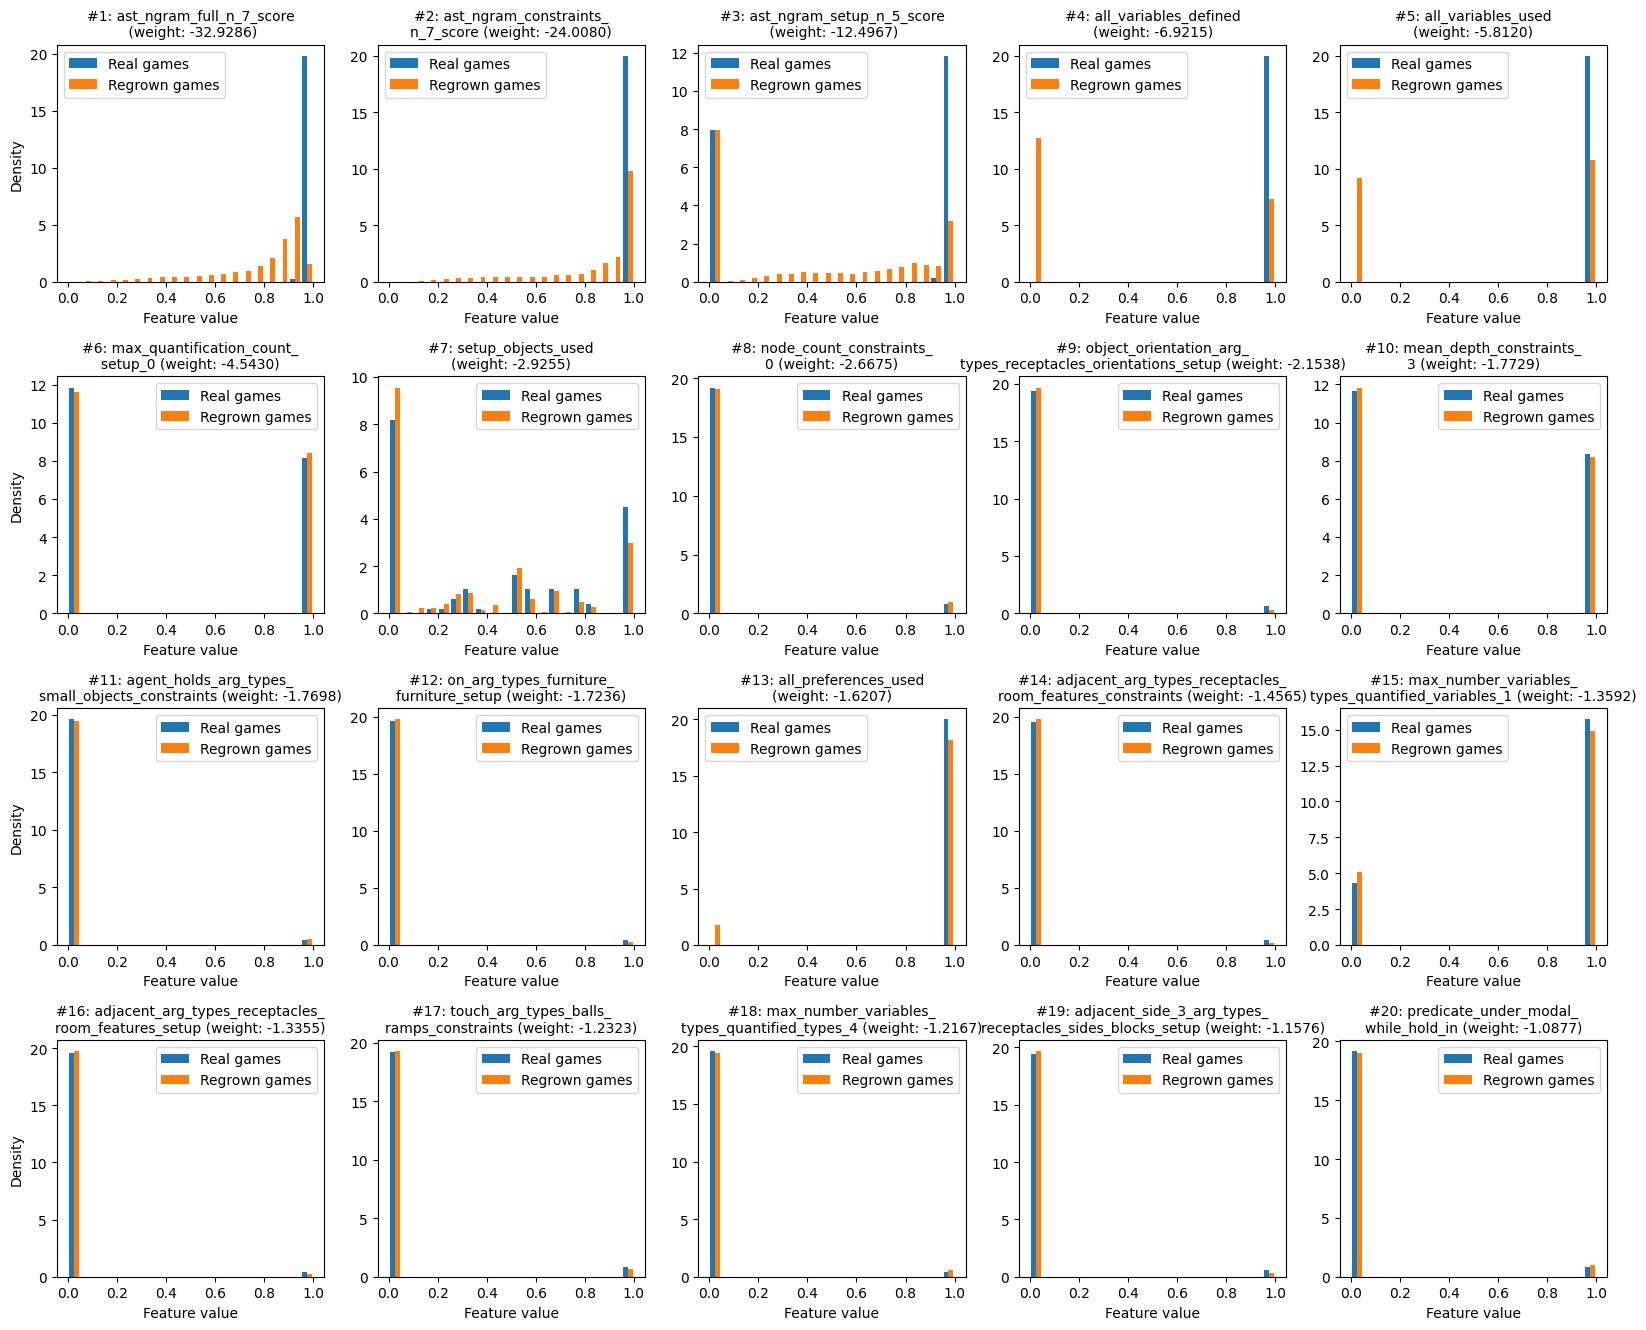

In [36]:
k = 20
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

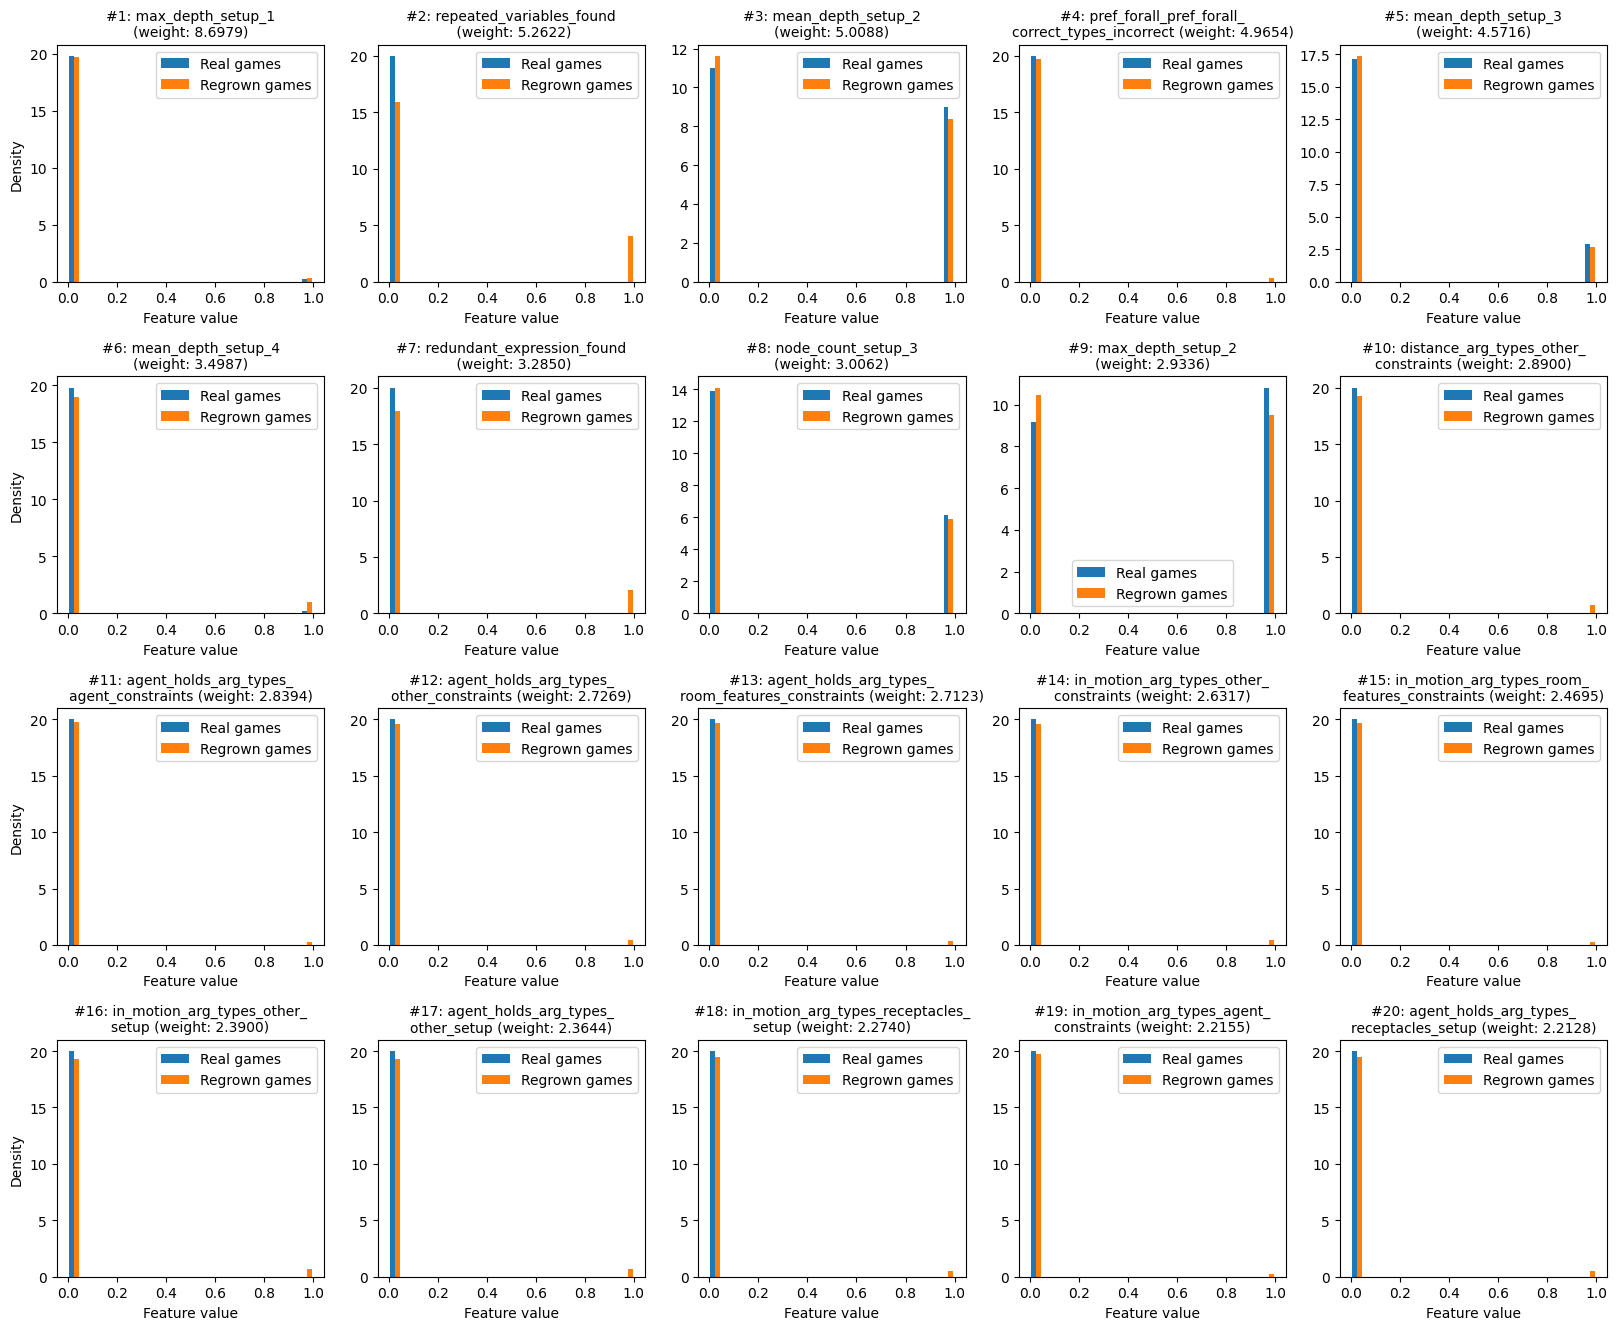

In [37]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [38]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [39]:
real_game_scores = full_tensor_scores[:, 0]
print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

Real game scores: -75.7723 ± 0.8908, min = -77.6675, max = -73.7659


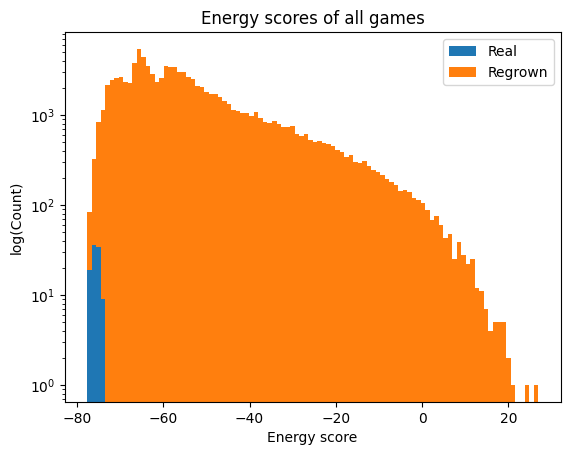

In [40]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [41]:
negatives_scores = full_tensor_scores[:, 1:]

In [42]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [43]:
torch.topk(score_diffs.ravel(), 10, largest=False)

torch.return_types.topk(
values=tensor([-1.5667, -1.5183, -1.4628, -1.4565, -1.1776, -1.1593, -1.1593, -0.9661,
        -0.7605, -0.7605]),
indices=tensor([91562,  6181, 88595, 21998, 77316, 76967, 77286, 53691, 15539, 15830]))

In [44]:
N_NEGATIVES = 10
for index in torch.topk(score_diffs.ravel(), N_NEGATIVES, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False, min_display_threshold=0.001)
    
    display(Markdown('---'))

Original game index: 89 | Negative game row: 89 | Negative game col: 426


### Energy of real game: -73.846 | Energy of regrown game: -75.413 | Difference: -1.567

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                                                   |
|--------------------------------------------|--------------------------------------------------------------------------------------------|
|                                            | adjacent_arg_types_receptacles_room_features_setup: **-1.336** = (0.000 => 1.000) * -1.336 |
|                                            | adjacent_arg_types_other_setup: **-0.231** = (1.000 => 0.000) * 0.231                      |

### Game Diffs

n,1,(define (game 5f0af097e7d15b3bf7734642-108) (:domain medium-objects-room-v1),n,1,(define (game 5f0af097e7d15b3bf7734642-108-426-nd-19-rd-1-rs-setup-sk-prior11) (:domain medium-objec
,,,,>,ts-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin ?b1 ?b2 - tall_cylindrical_block ?p1 ?p2 - pyramid_block ?b3 - cylin,,4,(exists (?h - hexagonal_bin ?b1 ?b2 - tall_cylindrical_block ?p1 ?p2 - pyramid_block ?b3 - cylin
,>,drical_block),,>,drical_block)
,5,(and,,5,(and
,6,(game-conserved,,6,(game-conserved
,7,(and,,7,(and
,8,(on side_table ?b3),,8,(on side_table ?b3)
,9,(on bed ?b1),,9,(on bed ?b1)


---

Original game index: 6 | Negative game row: 6 | Negative game col: 37


### Energy of real game: -75.514 | Energy of regrown game: -77.032 | Difference: -1.518

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                          | Features decreasing energy (= more real)                                                   |
|-------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| ast_ngram_full_n_7_score: **0.671** = (0.970 => 0.950) * -32.929  | adjacent_arg_types_receptacles_room_features_setup: **-1.336** = (0.000 => 1.000) * -1.336 |
| ast_ngram_setup_n_5_score: **0.143** = (0.983 => 0.972) * -12.497 | adjacent_arg_types_room_features_receptacles_setup: **-0.996** = (1.000 => 0.000) * 0.996  |

### Game Diffs

n,1,(define (game 615452aaabb932ada88ef3ca-9) (:domain many-objects-room-v1),n,1,(define (game 615452aaabb932ada88ef3ca-9-37-nd-16-rd-2-rs-setup-sk-prior6) (:domain many-objects-roo
,,,,>,m-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(or,,6,(or
,7,(on bed ?h),,7,(on bed ?h)
,8,(exists (?w - wall),,8,(exists (?w - wall)
t,9,(adjacent ?w ?h),t,9,(adjacent ?h ?w)
,10,),,10,)


---

Original game index: 86 | Negative game row: 86 | Negative game col: 531


### Energy of real game: -75.860 | Energy of regrown game: -77.323 | Difference: -1.463

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                   |
|--------------------------------------------|------------------------------------------------------------|
|                                            | setup_objects_used: **-1.463** = (0.500 => 1.000) * -2.926 |

### Game Diffs

n,1,(define (game 6106ac34408681f3b0d07396-104) (:domain few-objects-room-v1),n,1,(define (game 6106ac34408681f3b0d07396-104-531-nd-13-rd-2-rs-setup-sk-prior6) (:domain few-objects-r
,,,,>,oom-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin),,4,(exists (?h - hexagonal_bin)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
t,7,(equal_x_position east_sliding_door ?h),t,7,(equal_x_position rug ?h)
,8,),,8,)
,9,),,9,)
,10,),,10,)


---

Original game index: 21 | Negative game row: 21 | Negative game col: 494


### Energy of real game: -76.202 | Energy of regrown game: -77.658 | Difference: -1.457

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                                                         |
|--------------------------------------------|--------------------------------------------------------------------------------------------------|
|                                            | adjacent_arg_types_receptacles_room_features_constraints: **-1.457** = (0.000 => 1.000) * -1.457 |

### Game Diffs

n,1,(define (game 606e4eb2a56685e5593304cd-27) (:domain few-objects-room-v1),n,1,(define (game 606e4eb2a56685e5593304cd-27-494-nd-14-rd-2-rs-constraints-sk-prior1) (:domain few-obje
,,,,>,cts-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?d - (either dodgeball cube_block)),,4,(forall (?d - (either dodgeball cube_block))
,5,(game-optional,,5,(game-optional
,6,(not,,6,(not
,7,(exists (?s - shelf),,7,(exists (?s - shelf)
,8,(on ?s ?d),,8,(on ?s ?d)
,9,),,9,)
,10,),,10,)


---

Original game index: 75 | Negative game row: 75 | Negative game col: 516


### Energy of real game: -74.390 | Energy of regrown game: -75.567 | Difference: -1.178

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                          | Features decreasing energy (= more real)                                                            |
|-------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| ast_ngram_full_n_7_score: **0.613** = (0.972 => 0.954) * -32.929  | object_orientation_arg_types_receptacles_orientations_setup: **-2.154** = (0.000 => 1.000) * -2.154 |
| ast_ngram_setup_n_5_score: **0.363** = (0.979 => 0.950) * -12.497 |                                                                                                     |

### Game Diffs

n,1,(define (game 5fefd5b2173bfbe890bc98ed-88) (:domain few-objects-room-v1),n,1,(define (game 5fefd5b2173bfbe890bc98ed-88-516-nd-17-rd-1-rs-setup-sk-prior1) (:domain few-objects-ro
,,,,>,om-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin ?p - pillow ?b1 ?b2 ?b3 ?b4 ?b5 ?b6 - cube_block),,4,(exists (?h - hexagonal_bin ?p - pillow ?b1 ?b2 ?b3 ?b4 ?b5 ?b6 - cube_block)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
,7,(on bed ?h),,7,(on bed ?h)
,8,(not,,8,(not
,9,(object_orientation ?p sideways),,9,(object_orientation ?p sideways)
,10,),,10,)


---

Original game index: 75 | Negative game row: 75 | Negative game col: 167


### Energy of real game: -74.390 | Energy of regrown game: -75.549 | Difference: -1.159

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                          | Features decreasing energy (= more real)                                                            |
|-------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| ast_ngram_full_n_7_score: **0.631** = (0.972 => 0.953) * -32.929  | object_orientation_arg_types_receptacles_orientations_setup: **-2.154** = (0.000 => 1.000) * -2.154 |
| ast_ngram_setup_n_5_score: **0.363** = (0.979 => 0.950) * -12.497 |                                                                                                     |

### Game Diffs

n,1,(define (game 5fefd5b2173bfbe890bc98ed-88) (:domain few-objects-room-v1),n,1,(define (game 5fefd5b2173bfbe890bc98ed-88-167-nd-17-rd-1-rs-setup-sk-prior6) (:domain few-objects-ro
,,,,>,om-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin ?p - pillow ?b1 ?b2 ?b3 ?b4 ?b5 ?b6 - cube_block),,4,(exists (?h - hexagonal_bin ?p - pillow ?b1 ?b2 ?b3 ?b4 ?b5 ?b6 - cube_block)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
,7,(on bed ?h),,7,(on bed ?h)
,8,(not,,8,(not
t,9,(object_orientation ?p sideways),t,9,(object_orientation ?h sideways)
,10,),,10,)


---

Original game index: 75 | Negative game row: 75 | Negative game col: 486


### Energy of real game: -74.390 | Energy of regrown game: -75.549 | Difference: -1.159

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                          | Features decreasing energy (= more real)                                                            |
|-------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| ast_ngram_full_n_7_score: **0.631** = (0.972 => 0.953) * -32.929  | object_orientation_arg_types_receptacles_orientations_setup: **-2.154** = (0.000 => 1.000) * -2.154 |
| ast_ngram_setup_n_5_score: **0.363** = (0.979 => 0.950) * -12.497 |                                                                                                     |

### Game Diffs

n,1,(define (game 5fefd5b2173bfbe890bc98ed-88) (:domain few-objects-room-v1),n,1,(define (game 5fefd5b2173bfbe890bc98ed-88-486-nd-17-rd-1-rs-setup-sk-prior1) (:domain few-objects-ro
,,,,>,om-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?h - hexagonal_bin ?p - pillow ?b1 ?b2 ?b3 ?b4 ?b5 ?b6 - cube_block),,4,(exists (?h - hexagonal_bin ?p - pillow ?b1 ?b2 ?b3 ?b4 ?b5 ?b6 - cube_block)
,5,(game-conserved,,5,(game-conserved
,6,(and,,6,(and
,7,(on bed ?h),,7,(on bed ?h)
,8,(not,,8,(not
,9,(object_orientation ?p sideways),,9,(object_orientation ?p sideways)
,10,),,10,)


---

Original game index: 52 | Negative game row: 52 | Negative game col: 443


### Energy of real game: -75.162 | Energy of regrown game: -76.128 | Difference: -0.966

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                             | Features decreasing energy (= more real)                                             |
|--------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| in_motion_arg_types_large_objects_constraints: **0.487** = (1.000 => 0.000) * -0.487 | agent_holds_arg_types_receptacles_constraints: **-0.948** = (1.000 => 0.000) * 0.948 |
| in_motion_arg_types_furniture_constraints: **0.416** = (1.000 => 0.000) * -0.416     | in_motion_arg_types_receptacles_constraints: **-0.743** = (1.000 => 0.000) * 0.743   |
| ast_ngram_full_n_7_score: **0.174** = (0.977 => 0.972) * -32.929                     | on_arg_types_other_constraints: **-0.231** = (1.000 => 0.000) * 0.231                |
| ast_ngram_constraints_n_7_score: **0.108** = (0.987 => 0.983) * -24.008              | agent_holds_arg_types_furniture_constraints: **-0.230** = (1.000 => 0.000) * 0.230   |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-443-nd-10-rd-3-rs-constraints-sk-prior6) (:domain medium-o
,,,,>,bjects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - game_object)
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent desk agent) ) ),,7,(once (and (agent_holds ?o) (adjacent desk agent) ) )
,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) ),,8,(hold (and (not (agent_holds ?o) ) (in_motion ?o) ) )
,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) ),,9,(once (and (not (in_motion ?o) ) (on bed ?o) ) )
,10,),,10,)


---

Original game index: 15 | Negative game row: 15 | Negative game col: 179


### Energy of real game: -75.027 | Energy of regrown game: -75.787 | Difference: -0.761

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                                                 |
|--------------------------------------------|------------------------------------------------------------------------------------------|
|                                            | distance_arg_types_receptacles_agent_constraints: **-0.761** = (0.000 => 1.000) * -0.761 |

### Game Diffs

n,1,(define (game 60e93f64ec69ecdac3107555-19) (:domain medium-objects-room-v1),n,1,(define (game 60e93f64ec69ecdac3107555-19-179-nd-23-rd-1-rs-constraints-sk-prior6) (:domain medium-o
,,,,>,bjects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?b - ball),,4,(forall (?b - ball)
,5,(game-optional,,5,(game-optional
,6,(< (distance door ?b) 1),,6,(< (distance door ?b) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)


---

Original game index: 15 | Negative game row: 15 | Negative game col: 470


### Energy of real game: -75.027 | Energy of regrown game: -75.787 | Difference: -0.761

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                                                 |
|--------------------------------------------|------------------------------------------------------------------------------------------|
|                                            | distance_arg_types_receptacles_agent_constraints: **-0.761** = (0.000 => 1.000) * -0.761 |

### Game Diffs

n,1,(define (game 60e93f64ec69ecdac3107555-19) (:domain medium-objects-room-v1),n,1,(define (game 60e93f64ec69ecdac3107555-19-470-nd-22-rd-1-rs-constraints-sk-prior11) (:domain medium-
,,,,>,objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(forall (?b - ball),,4,(forall (?b - ball)
,5,(game-optional,,5,(game-optional
,6,(< (distance door ?b) 1),,6,(< (distance door ?b) 1)
,7,),,7,)
,8,),,8,)
,9,),,9,)
,10,),,10,)


---

In [28]:
d = data_df[data_df.game_name.isin(['5f8d77f0b348950659f1919e-41', '5f8d77f0b348950659f1919e-41-145-nd-20-rd-1-rs-setup-sk-prior6'])][feature_columns]
diff = d.iloc[0] - d.iloc[1]
diff_nonzero = diff[diff != 0]
for d in diff_nonzero.index:
    weight = weights[feature_columns.index(d)]
    print(d, diff_nonzero[d], weight, weight * diff_nonzero[d])


setup_objects_used -0.25 tensor(-0.2921) tensor(0.0730)


## If we never need to load a featurizer for anything


In [ ]:
from src.fitness_features import *
with gzip.open('../models/fitness_featurizer_2023_02_14.pkl.gz', 'rb') as f:
    featurizer = pickle.load(f)  # type: ignore

## Analyzing the role of different variables on the difficulty of the negative

In [ ]:
NEGATIVE_DIFFICULTY_COLUMNS = [
    'game_name', 'regrowth_index', 
    'original_game_name', 'original_game_index', 
    'node_depth', 'regrowth_depth', 
    'regrowth_section', 'regrowth_sampler', 
    'score_diff'
]

def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)


game_name_to_index = {game_name: i for i, game_name in enumerate(data_df.loc[data_df.real == 1, 'game_name'])}


def extract_info_from_game_name(game_name: str):
    i = utils._find_nth(game_name, '-', 2)
    original_game_name, regrowth_info = game_name[:i], game_name[i + 1:]
    regrowth_index, _, node_depth, _, regrowth_depth, _, regrowth_section, _, regrowth_sampler = regrowth_info.split('-')
    regrowth_index = int(regrowth_index)
    node_depth = int(node_depth)
    regrowth_depth = int(regrowth_depth)
    original_game_index = game_name_to_index[original_game_name]
    score_diff = score_diffs[original_game_index, regrowth_index].item()
    return [regrowth_index, original_game_name, original_game_index, node_depth, regrowth_depth, regrowth_section, regrowth_sampler, score_diff]


negative_difficulty_df = data_df.loc[data_df.real == 0, ['game_name']]
negative_difficulty_df = apply_and_concat(negative_difficulty_df, 'game_name', extract_info_from_game_name, NEGATIVE_DIFFICULTY_COLUMNS[1:])




In [ ]:
negative_difficulty_df.head()

In [ ]:
negative_difficulty_df.groupby('regrowth_sampler').score_diff.describe()

In [ ]:
negative_difficulty_df.groupby('regrowth_section').score_diff.describe()

In [ ]:
def sem(x):
    return np.std(x) / np.sqrt(len(x))

regrowth_depth_impact = negative_difficulty_df.groupby('regrowth_depth').score_diff.agg(['mean', sem])

In [ ]:

plt.plot(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, 'o', linestyle='-')
plt.errorbar(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, regrowth_depth_impact['sem'].values, linestyle='None')
plt.xlabel('Regrown tree depth')
plt.ylabel('Mean energy difference (lower is harder)')
plt.title('Mean energy difference by regrown tree depth')
# regrowth_depth_impact['mean']